In [ ]:
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
import kagglehub

path = kagglehub.dataset_download("youssefaboelwafa/clustering-penguins-species")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/clustering-penguins-species


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/youssefaboelwafa/clustering-penguins-species/versions/1"
file_name = "penguins.csv"
full_path = os.path.join(dataset_path, file_name)

In [ ]:
df = pd.read_csv(full_path)
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [ ]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,214.014620,4201.754386
std,5.459584,1.974793,260.558057,801.954536
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.750000,4750.000000
max,59.600000,21.500000,5000.000000,6300.000000


In [ ]:
df.isna().sum()

,0
culmen_length_mm,2
culmen_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


### Заполним пропуски и перекодируем данные

In [ ]:
df['sex'] = df['sex'].map({'MALE': 0, 'FEMALE': 1})

In [ ]:
for col in df.columns:
    if df[col].dtype == 'float64':
        median = df[col].median()
        df[col] = df[col].fillna(median)

In [ ]:
df.isna().sum()

,0
culmen_length_mm,0
culmen_depth_mm,0
flipper_length_mm,0
body_mass_g,0
sex,0


### **Preprocessing**

In [ ]:
SS=StandardScaler()

X=pd.DataFrame(SS.fit_transform(df), columns=df.columns)

In [ ]:
X.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.887622,0.787289,-0.126881,-0.564625,-0.960098
1,-0.814037,0.126114,-0.107607,-0.502010,1.041561
2,-0.666866,0.431272,-0.072915,-1.190773,1.041561
3,0.096581,0.075255,-0.065205,-0.188936,-0.960098
4,-1.329133,1.092447,-0.080624,-0.940314,1.041561


## PCA

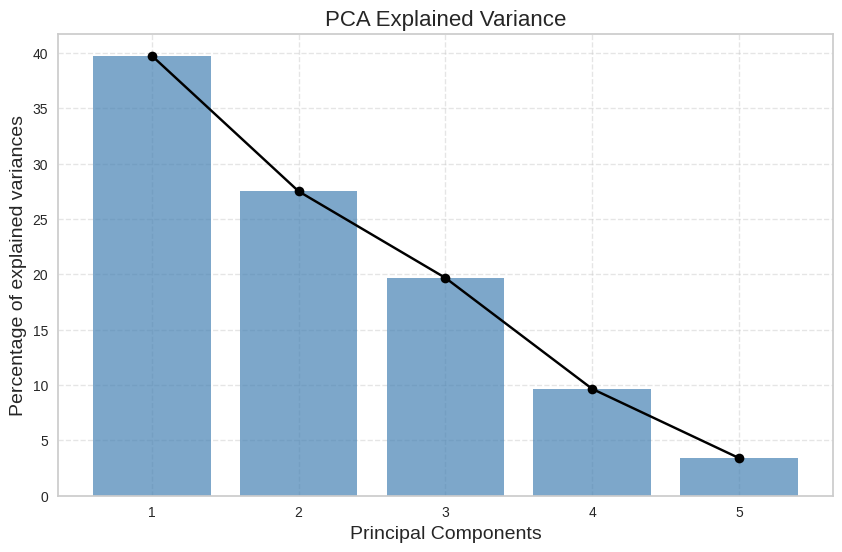

In [ ]:
pca = PCA()
pca = pca.fit(X)

explained_variance = pca.explained_variance_ratio_ * 100  # проценты дисперсии
components = np.arange(1, len(explained_variance) + 1)

# Строим график
plt.figure(figsize=(10,6))
plt.bar(components, explained_variance, alpha=0.7, color='steelblue')
plt.plot(components, explained_variance, 'o-', color='black')

plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Percentage of explained variances', fontsize=14)
plt.xticks(components)
plt.title('PCA Explained Variance', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

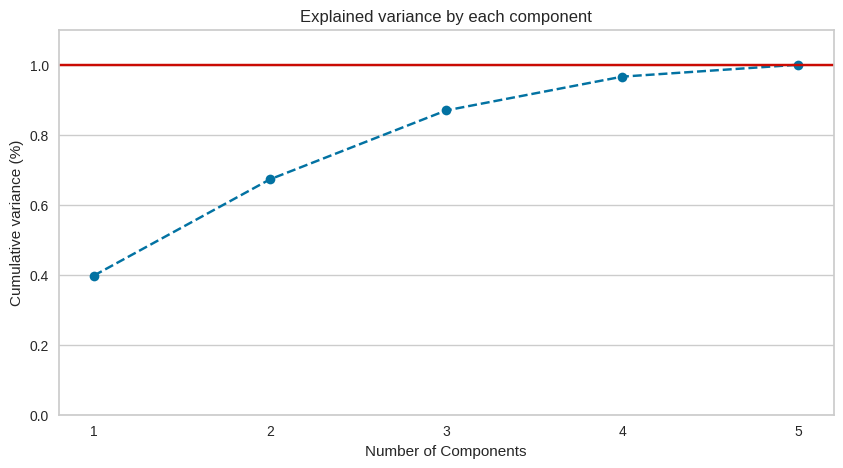

In [ ]:
pca_var = PCA()
pca_var.fit(X)

plt.figure(figsize=(10,5))
xi = np.arange(1, 1+X.shape[1], step=1)
yi = np.cumsum(pca_var.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.gca().xaxis.grid(False)

### примерно 87% в сумме три признака, что хорошо

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

principal_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])

print(principal_df.shape)
principal_df.head()

(344, 2)


,PC1,PC2
0,-0.817654,1.176238
1,-1.214096,-0.638911
2,-1.675451,-0.365388
3,0.239039,0.704509
4,-2.114689,0.055912


In [ ]:
from yellowbrick.cluster import KElbowVisualizer

Text(0, 0.5, 'PC2')

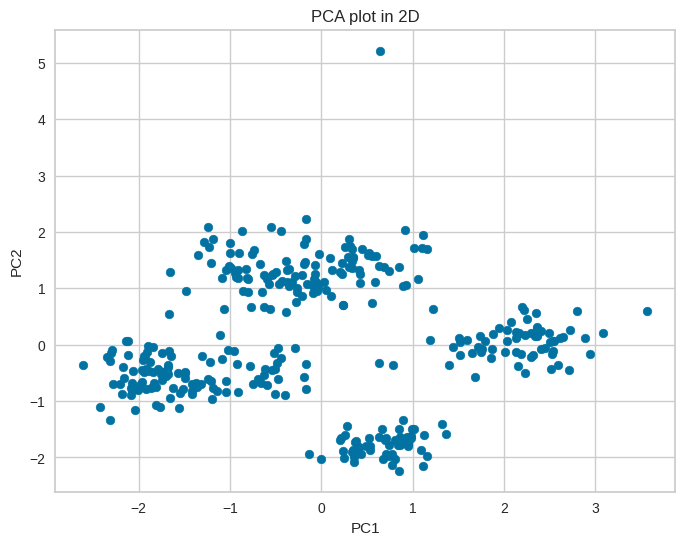

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(principal_df.iloc[:,0], principal_df.iloc[:,1], s=40)

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')

### После применения PCA очень похоже на 4 кластера

In [ ]:
# технические параметры k-means, которые мы будем использовать дальше
kmeans_params = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300,
    'tol': 0.0001,
    'random_state': 42,
    'algorithm': 'elkan'
}

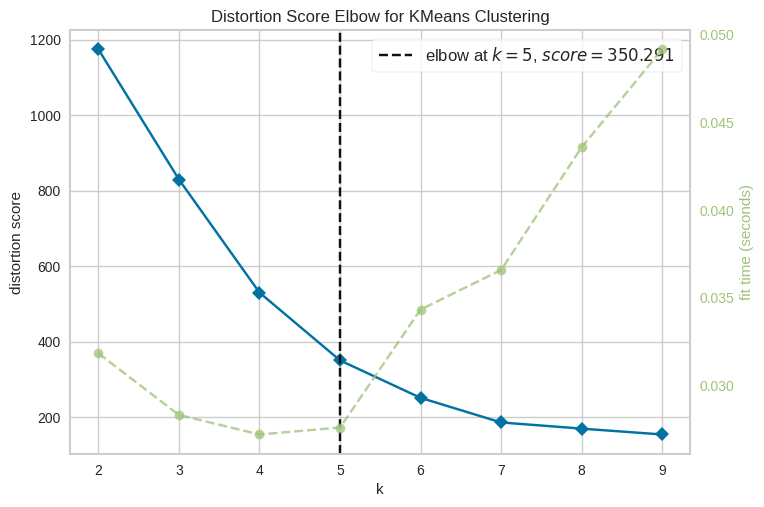

In [ ]:
model = KMeans(**kmeans_params)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X)
visualizer.show()
plt.show()

### Дальше мне стало интересно посмотреть на эти данные, используя t-sne и umap,использовать разные методы кластеризации

##**DBSCAN**

In [ ]:
eps_values = np.arange(0.4, 1.4, 0.25)
min_samples = np.arange(3, 10)

DBSCAN_params = list(product(eps_values, min_samples))

In [ ]:
num_clusters = []
num_outliers = []
sil_score = []

for eps, min_samples in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    num_clusters.append(len(np.unique(DBS_clustering.labels_[DBS_clustering.labels_>=0])))
    num_outliers.append((DBS_clustering.labels_==-1).astype(int).sum())
    sil_score.append(silhouette_score(X, DBS_clustering.labels_))

tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['num_clusters'] = num_clusters
tmp['num_outliers'] = num_outliers
tmp['sil_score'] = sil_score

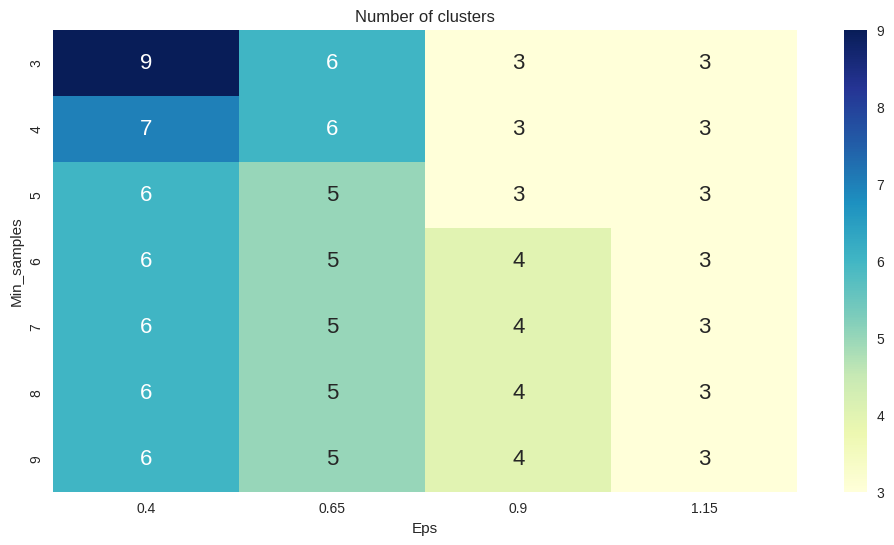

In [ ]:
pivot_1 = pd.pivot_table(tmp, values='num_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

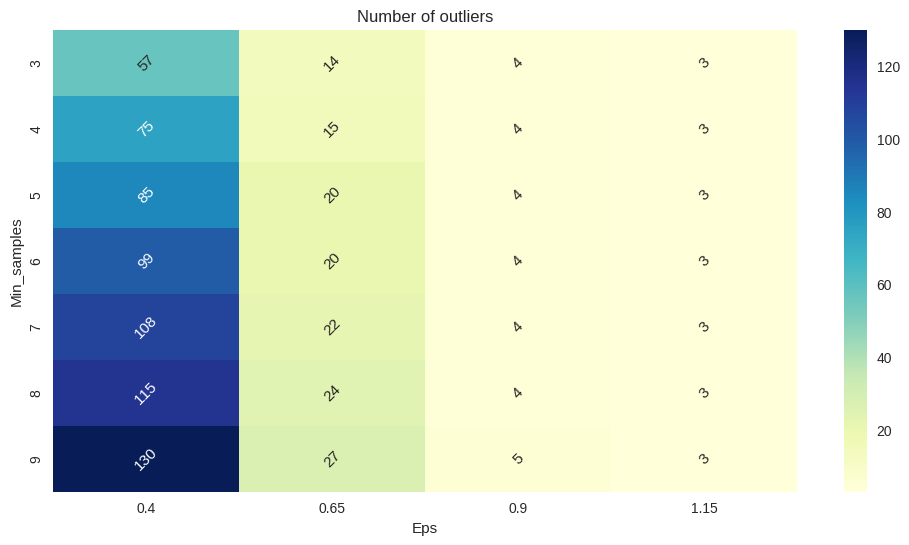

In [ ]:
pivot_2 = pd.pivot_table(tmp, values='num_outliers', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_2, annot=True, annot_kws={"size": 11, 'rotation': 45}, cmap="YlGnBu", ax=ax, fmt='.3g')
ax.set_title('Number of outliers')
plt.show()

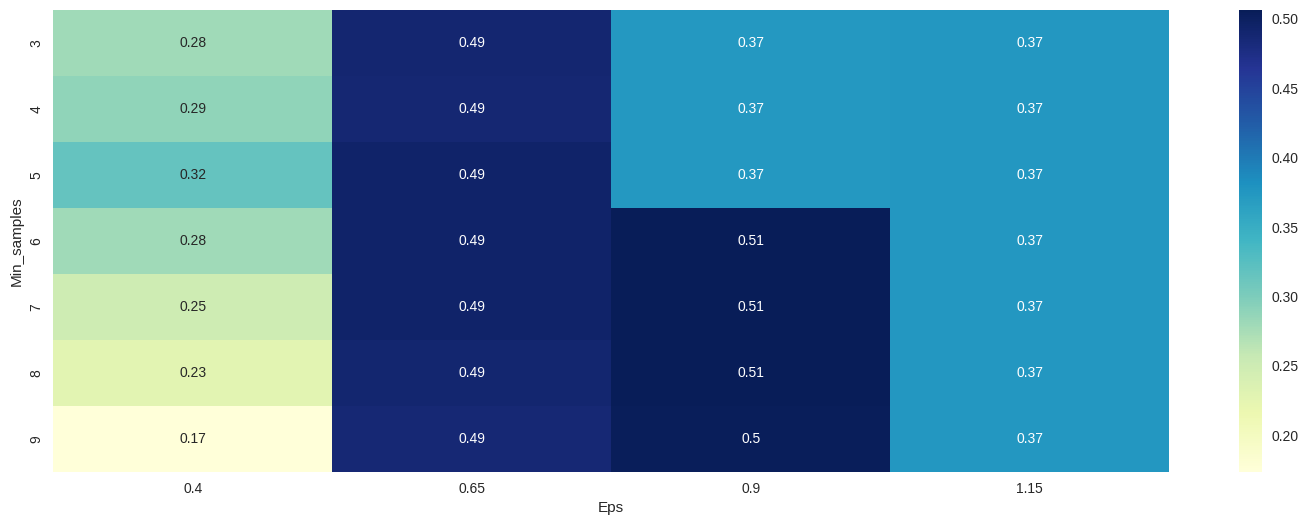

In [ ]:
pivot_3 = pd.pivot_table(tmp, values='sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_3, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [ ]:
eps, min_samples = DBSCAN_params[np.argmax(sil_score)]
print(f"min_samples: {min_samples}, eps: {eps}")

min_samples: 6, eps: 0.9


### максимум достигается при параметрах eps = 0.9 и min_samples 6

## **MeanShift**

In [ ]:
params = np.arange(0.01, 0.21, 0.01)
num_clusters = []
sil_score = []
bandwidths = []

for quantile in params:
    bandwidth = estimate_bandwidth(X, quantile=quantile)
    mean_shift = MeanShift(bandwidth=bandwidth).fit(X)
    bandwidths.append(bandwidth)
    num_clusters.append(len(np.unique(mean_shift.labels_)))
    if len(np.unique(mean_shift.labels_)) == 1:
        sil_score.append(0.0)
    else:
        sil_score.append(silhouette_score(X, mean_shift.labels_))

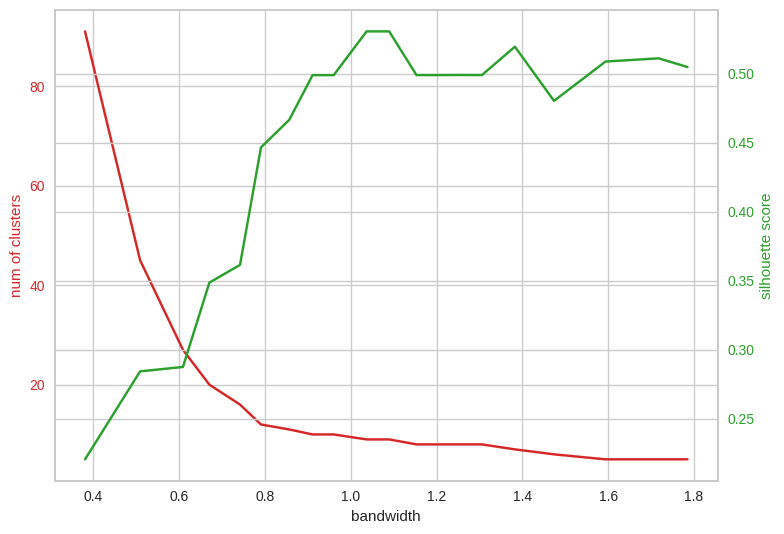

In [ ]:
fig, ax1 = plt.subplots()

color='tab:red'
ax1.set_xlabel('bandwidth')
ax1.set_ylabel('num of clusters', color='tab:red')
ax1.plot(bandwidths, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel('silhouette score', color=color)
ax2.plot(bandwidths, sil_score, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [ ]:
quantile = params[np.argmax(sil_score)]
bandwidth = bandwidths[np.argmax(sil_score)]
print('quantile: {:.2f}, bandwidth: {:.2f}'.format(quantile, bandwidth))

quantile: 0.10, bandwidth: 1.04


## **Hierarchical**

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

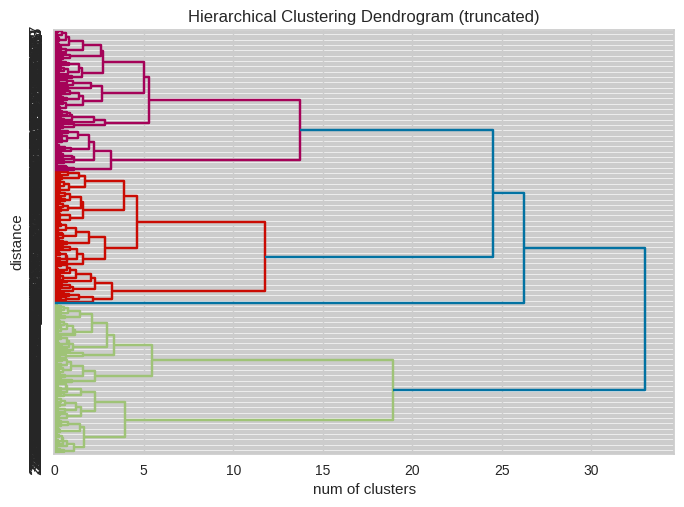

In [ ]:
H_cluster = linkage(X,'ward')

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('num of clusters')
plt.ylabel('distance')

dendrogram(
    H_cluster,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    orientation='right'
)
plt.show()

In [ ]:
params = list(range(2, 20))
num_clusters = []
sil_score = []

for n_clusters in params:
    aglom_clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(X)
    num_clusters.append(len(np.unique(aglom_clust.labels_)))
    sil_score.append(silhouette_score(X, aglom_clust.labels_))

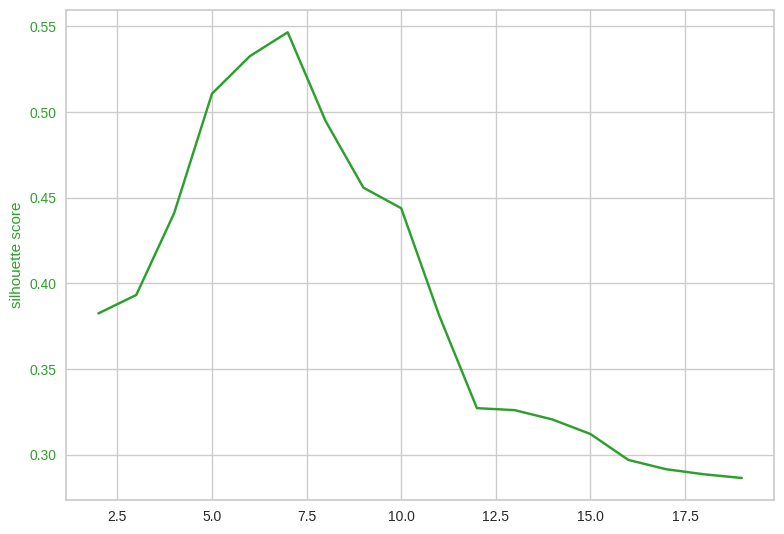

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_ylabel('silhouette score', color=color)
ax1.plot(params, sil_score, color=color)
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [ ]:
n_clusters = params[np.argmax(sil_score)]
print(f"n_clusters: {n_clusters}")

n_clusters: 7


### Сравним разные методы кластеризации, применяя понижение размерности (t-sne, umap, pca)

In [ ]:
def compute_centroids(X, labels):
    centroids = []
    for label in np.unique(labels):
        if label == -1:  # -1 = noise (DBSCAN)
            continue
        mask = labels == label
        cluster_center = X[mask].mean(axis=0)
        centroids.append(cluster_center)
    return np.array(centroids)

In [ ]:
def plot_clustering(ax, X, labels, centroids=None, title=""):
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=40, alpha=0.8)
    if centroids is not None and len(centroids) > 0:
        ax.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, marker='X', label='Centroids')
        ax.legend()
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.grid(True, linestyle='--', alpha=0.9)

In [ ]:

def plot_clustering_comparison(X, method='pca', n_clusters=5, eps=0.9, min_samples=6, quantile=0.1):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)

    X_2d = reducer.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels_kmeans = kmeans.fit_predict(X_2d)
    centroids_kmeans = kmeans.cluster_centers_

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels_dbscan = dbscan.fit_predict(X_2d)
    centroids_dbscan = compute_centroids(X_2d, labels_dbscan)

    bandwidth = estimate_bandwidth(X_2d, quantile=quantile)
    bandwidth = round(bandwidth, 2) if bandwidth > 0 else 1.0
    meanshift = MeanShift(bandwidth=bandwidth)
    labels_meanshift = meanshift.fit_predict(X_2d)
    centroids_meanshift = meanshift.cluster_centers_

    agglom = AgglomerativeClustering(n_clusters=7, linkage='ward')
    labels_agg = agglom.fit_predict(X_2d)
    centroids_agg = compute_centroids(X_2d, labels_agg)

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    plot_clustering(axs[0, 0], X_2d, labels_kmeans, centroids_kmeans, title="KMeans")
    plot_clustering(axs[0, 1], X_2d, labels_dbscan, centroids_dbscan, title="DBSCAN")
    plot_clustering(axs[1, 0], X_2d, labels_meanshift, centroids_meanshift, title=f"MeanShift (bw={bandwidth})")
    plot_clustering(axs[1, 1], X_2d, labels_agg, centroids_agg, title="Agglomerative")

    plt.suptitle(f"Сравнение кластеризации ({method.upper()})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


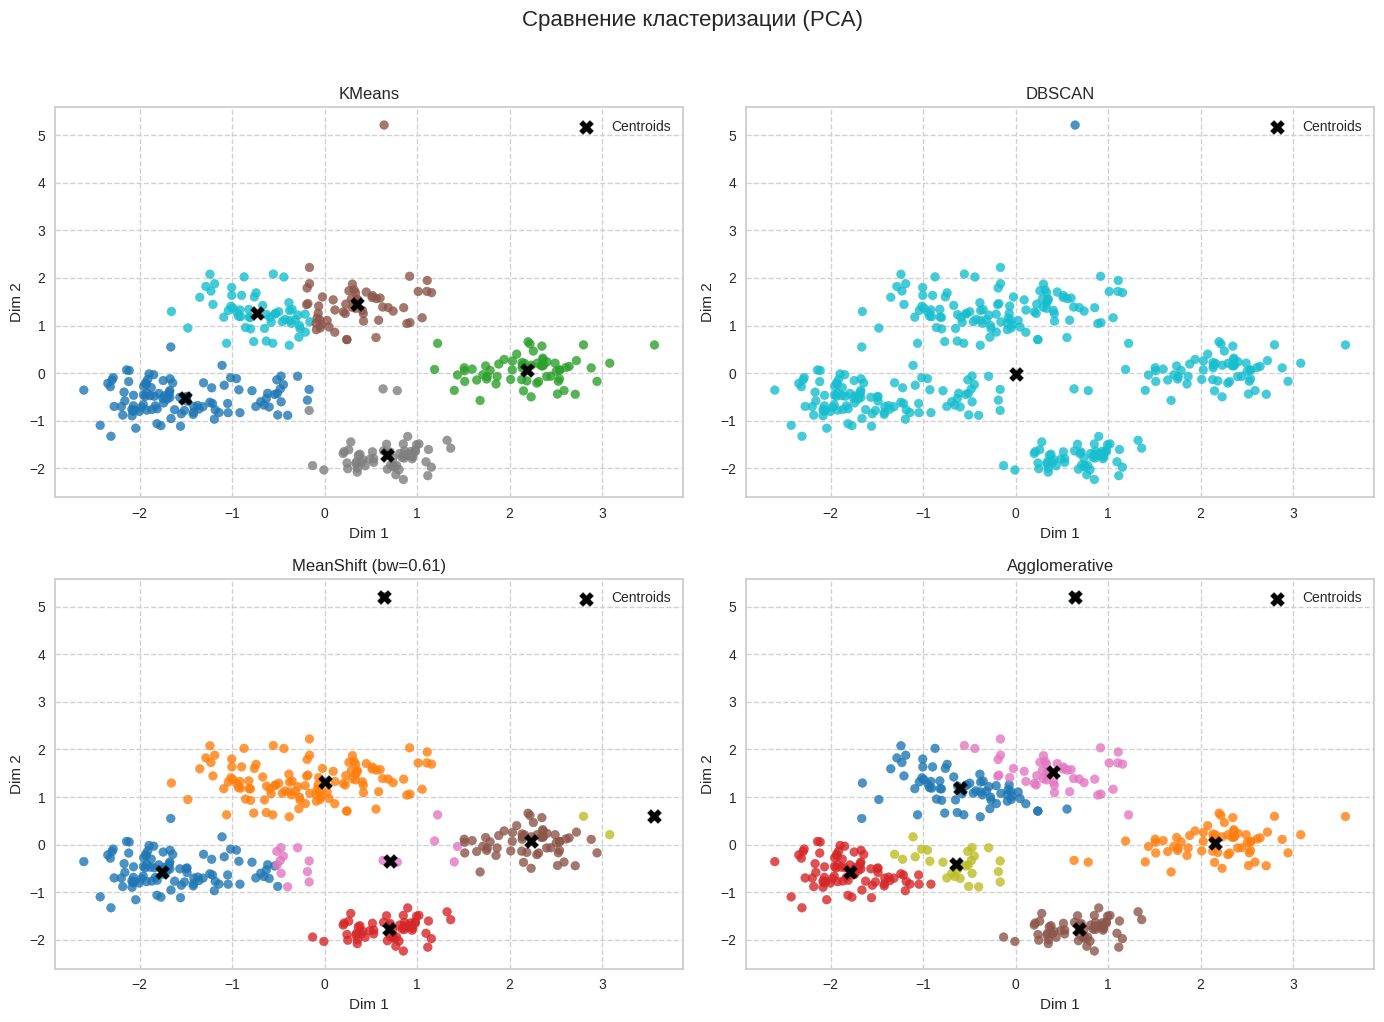

In [ ]:
plot_clustering_comparison(X, method='pca')

##**Вывод:** Кластеры сильно перекрываются, только KMeans и Agglomerative дали относительно хорошее разделение, dbscan определил почти всё как один кластер, meanshift наоборот создал много мелких кластеров. Что интересно, разные алгоритмы показывают разные кластеры

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



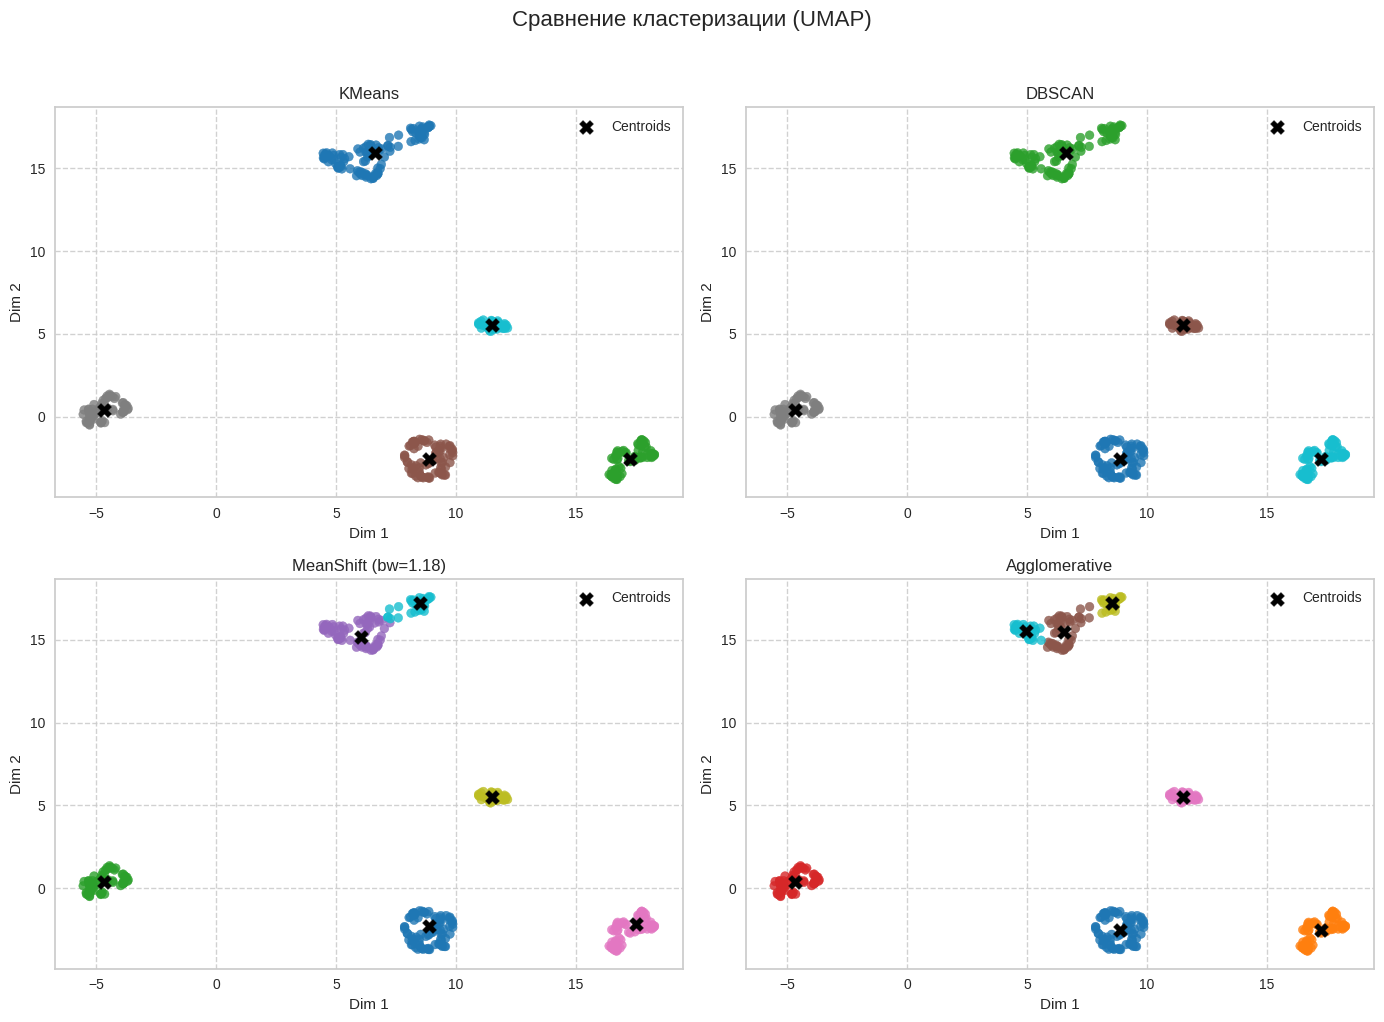

In [ ]:
plot_clustering_comparison(X, method='umap')

### Вывод: uman - точно разделил на кластеры. Kmeans и dbscan разделили идентично на 5 кластеров. MeanShift выделил 6 кластеров, а agglomerative - 7

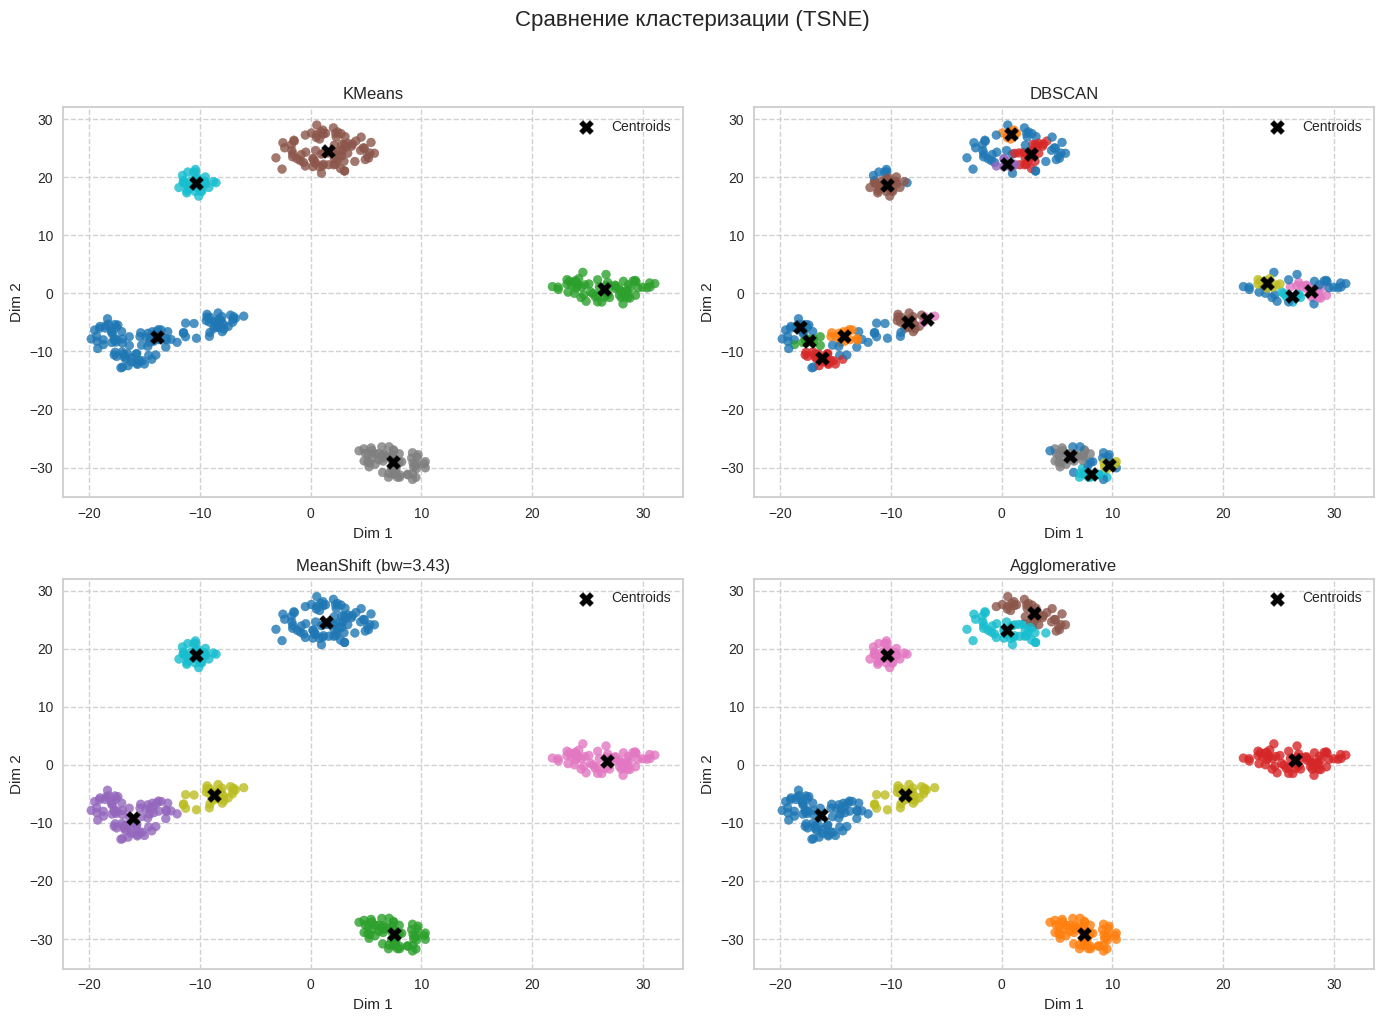

In [ ]:
plot_clustering_comparison(X, method='tsne')

## **Вывод:** Очень хорошо справился kmeans, meanshift и agglomerative, но вот dbscan показал плохой результат, это связано с тем, что он не учитывает глобальную структуру данных

## Так как umap показал себя лучше всего, то попробуем нарисовать графики в 3d

In [ ]:
def compute_cluster_stats(name, model, data):
    labels = model.fit_predict(data)

    if name == 'DBSCAN':
        mask = labels != -1
        valid_labels = labels[mask]
        n_outliers = np.sum(~mask)
        n_clusters = len(set(valid_labels))
        silhouette = silhouette_score(data[mask], valid_labels) if n_clusters > 1 else np.nan
    else:
        valid_labels = labels
        n_outliers = 0
        n_clusters = len(set(valid_labels))
        silhouette = silhouette_score(data, valid_labels) if n_clusters > 1 else np.nan

    sizes = pd.Series(valid_labels).value_counts()
    return {
        'Алгоритм кластеризации': name,
        'Количество кластеров': n_clusters,
        'Количество выбросов': n_outliers,
        'Silhouette score': round(silhouette, 4) if not np.isnan(silhouette) else np.nan,
        'Минимальный размер кластера': sizes.min(),
        'Максимальный размер кластера': sizes.max(),
        'Средний размер кластера': int(sizes.mean())
    }, labels

In [ ]:
def plot_clustering_comparison_3d_umap(X, n_clusters=5, eps=0.9, min_samples=6, quantile=0.10):
    reducer = umap.UMAP(n_components=3, random_state=42)
    X_3d = reducer.fit_transform(X)
    bandwidth = round(estimate_bandwidth(X_3d, quantile=quantile), 2)
    bandwidth = bandwidth if bandwidth > 0 else 1.0

    clusterers = {
        'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
        'DBSCAN': DBSCAN(eps=eps, min_samples=min_samples),
        'MeanShift': MeanShift(bandwidth=bandwidth),
        'Agglomerative': AgglomerativeClustering(n_clusters=7, linkage='ward')
    }

    fig = plt.figure(figsize=(18, 12))
    overview = []

    for i, (name, model) in enumerate(clusterers.items(), start=1):
        stats, labels = compute_cluster_stats(name, model, X_3d)
        centroids = compute_centroids(X_3d, labels)
        overview.append(stats)

        ax = fig.add_subplot(2, 2, i, projection='3d')
        ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=labels, cmap='tab10', s=30, alpha=0.8)
        if centroids.size > 0:
            ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='black', s=100, marker='X', label='Centroids')
        ax.set_title(stats['Алгоритм кластеризации'])
        ax.set_xlabel('UMAP-1')
        ax.set_ylabel('UMAP-2')
        ax.set_zlabel('UMAP-3')
        ax.legend()

    plt.suptitle("Сравнение кластеризации (UMAP 3D)", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(overview)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



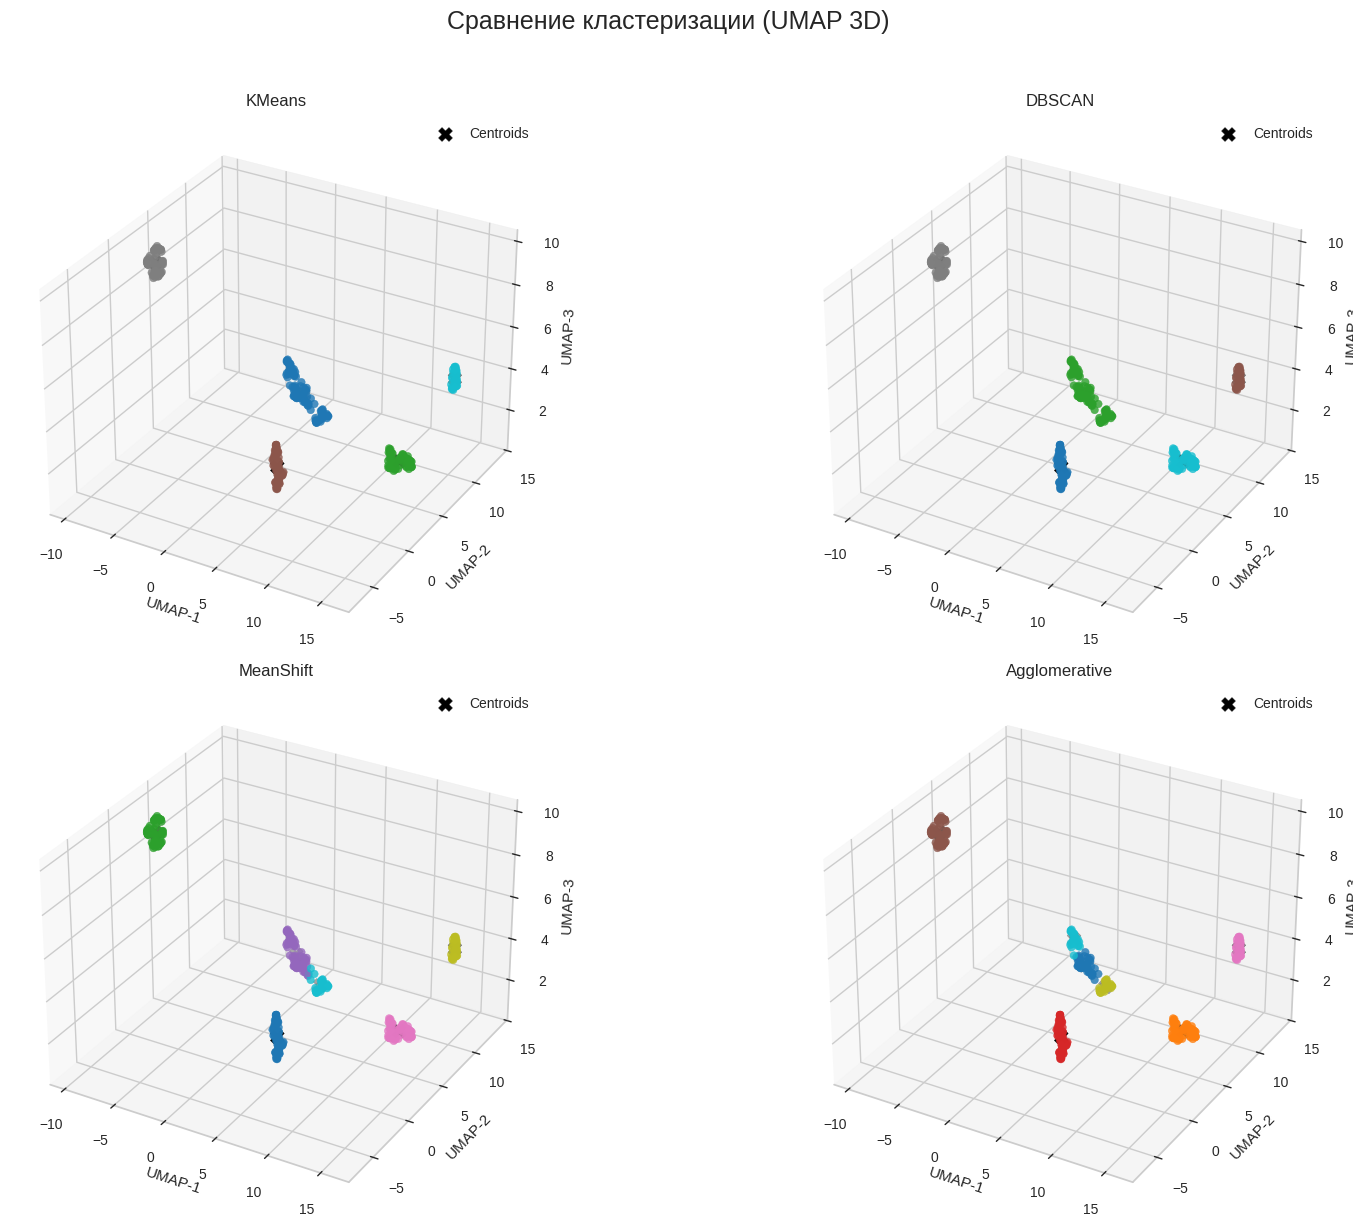

,Алгоритм кластеризации,Количество кластеров,Количество выбросов,Silhouette score,Минимальный размер кластера,Максимальный размер кластера,Средний размер кластера
0,KMeans,5,0,0.8881,34,107,68
1,DBSCAN,5,0,0.8881,34,107,68
2,MeanShift,6,0,0.8180,32,80,57
3,Agglomerative,7,0,0.7934,28,80,49


In [ ]:
df_overview = plot_clustering_comparison_3d_umap(X, n_clusters=5, eps=0.9, min_samples=6, quantile=0.1)
df_overview

## В данном случае лучший показатель - 0.8881 у алгоритма Kmeans и Dbscan

# Вывод: в зависимости от данных надо пробоват разные способы понижения размерности и применять различные алгоритмы кластеризации. Мне очень понравился umap.